# MAT 201A Homework 2
Chengyuan Xu, 18 Spring

**Part 1 & 2 are for Homework 2**, Part 3 and beyong is for future work  

Previous work similar to HW2 -  
video - https://www.youtube.com/watch?v=BC4MZ5tqz0U   
full - http://cyxu.tv/portfolio/musical-realization-of-images/  

## Part 0. morse code visualizer - workflow

**input:** Morse Code sound file ->  
binary conversion into int array (alternative representation of - and .) ->  
slicing and decoding to alphabets ->  
meaningful string of words ->  
**output:** first Google image serach result of the string  

In [194]:
from IPython.display import Image
from scipy.io import wavfile
from scipy.stats import mode
from scipy import signal
from __future__ import print_function
from __future__ import division
from ipywidgets import widgets, interact

%pylab inline

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

rcParams['figure.figsize'] = (20, 8) #wide graphs by default

Populating the interactive namespace from numpy and matplotlib


## Part 1. raed and understand a morse audio clip

/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Sample length: 731005 , Max 204 , Min 50 Mean 127


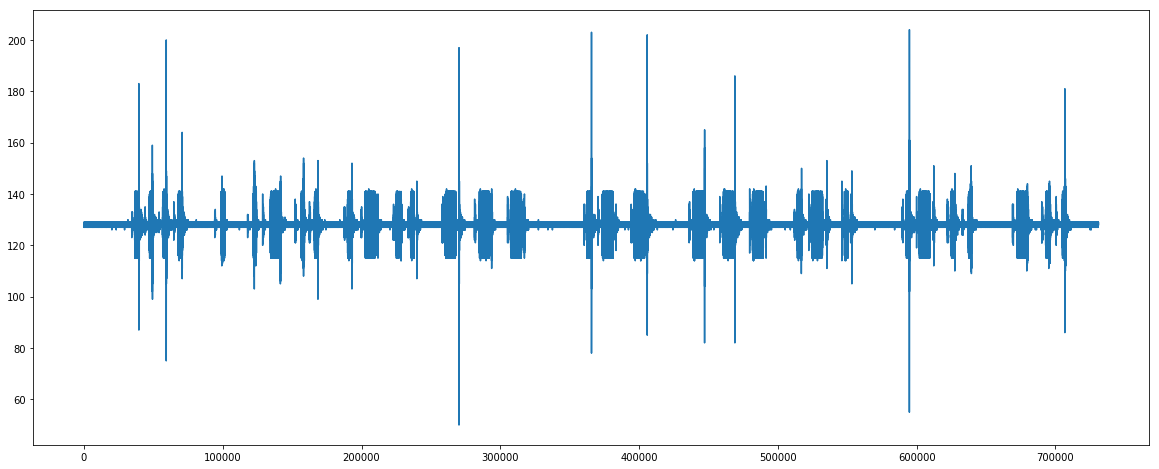

In [195]:
filepath = './media/morse_sample.wav'
sampleRate, morse = wavfile.read(filepath)

print("Sample length:", len(morse), ", Max", max(morse), ", Min",min(morse), "Mean",int(mean(morse)))
plot(morse)

# abolute value of audio would 
morse = abs(morse - median(morse))

In [196]:
# define and test two hand written moving average filter

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

# from scipy.signal import *
# morse2 = symiirorder1(morse, 0.0001, 0.99)
# morse2 = running_mean(morse, 10)

### 1.1 Filter signal noise

medfilt(morse,31)      length 731005 Max 16 Min 0 Mean 1 Median 0
running_mean(morse,31) length 730975 Max 32 Min 0 Mean 1 Median 0


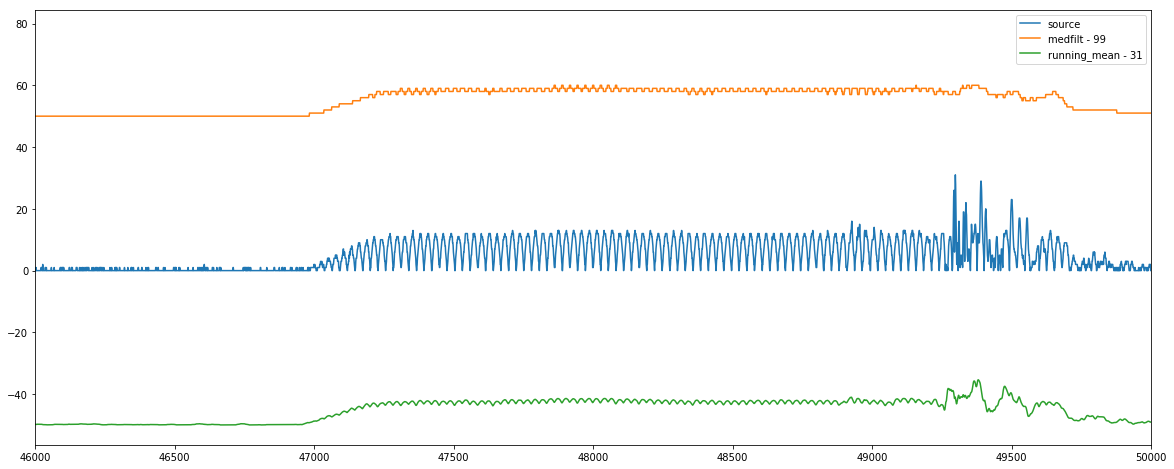

In [197]:
# calling scipy median_filter to get clean signal
# compare results from different filters
# x-axis is zoomed into one section (46000, 50000)

# morse2 = scipy.signal.medfilt(morse,51)
morse2 = signal.medfilt(morse,99)
print("medfilt(morse,31)     ", "length", len(morse2), "Max", int(max(morse2)), "Min", int(min(morse2)), "Mean",int(mean(morse2)), "Median", int(median(morse2)))
morse2 = 50 + morse2[:]

morse3 = running_mean(morse,31)
# morse3 = signal.detrend(morse, type='constant')
print("running_mean(morse,31)", "length", len(morse3), "Max", int(max(morse3)), "Min", int(min(morse3)), "Mean",int(mean(morse3)), "Median", int(median(morse3)))
morse3 = -50 + morse3[:]

plt.xlim(46000, 50000)
plot(morse, label='source')
plt.xlim(46000, 50000)
plot(morse2, label='medfilt - 99')
plt.xlim(46000, 50000)
plot(morse3, label='running_mean - 31')
legend(loc='best')
pass

16.0 1.915503997920671 ModeResult(mode=array([0.]), count=array([489595])) 3.3871840558384836


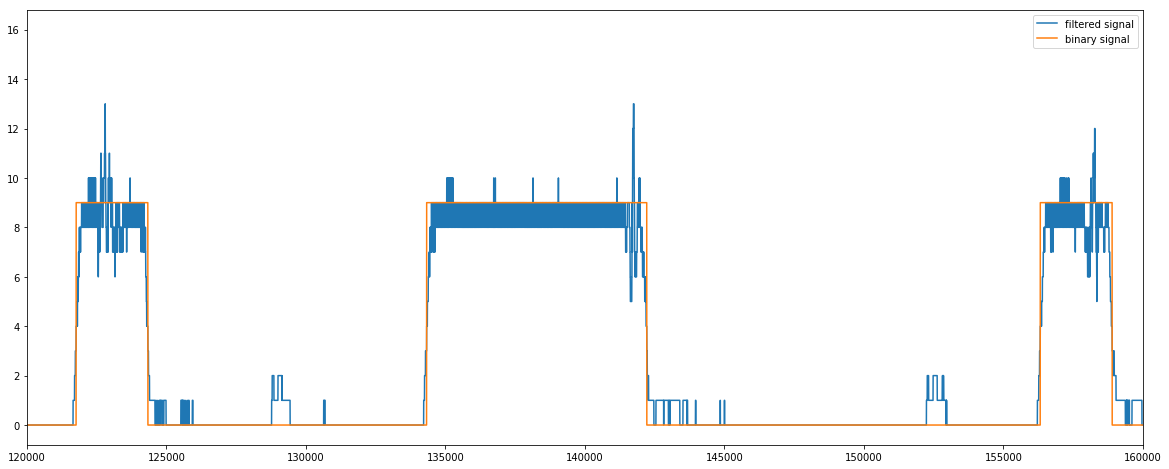

In [198]:
# picking the medfilt and apply a threshold

morseCode = morse2 - median(morse2) # reset median to 0
print(max(morseCode), mean(morseCode), mode(morseCode), std(morseCode))
plot(morseCode,label='filtered signal')

threshold = 0 + 1 * std(morseCode)
morseCode[morseCode > threshold] = 9
morseCode[morseCode < threshold] = 0

plot(morseCode, label='binary signal')
plt.xlim(120000, 160000) 
legend(loc='best')
pass

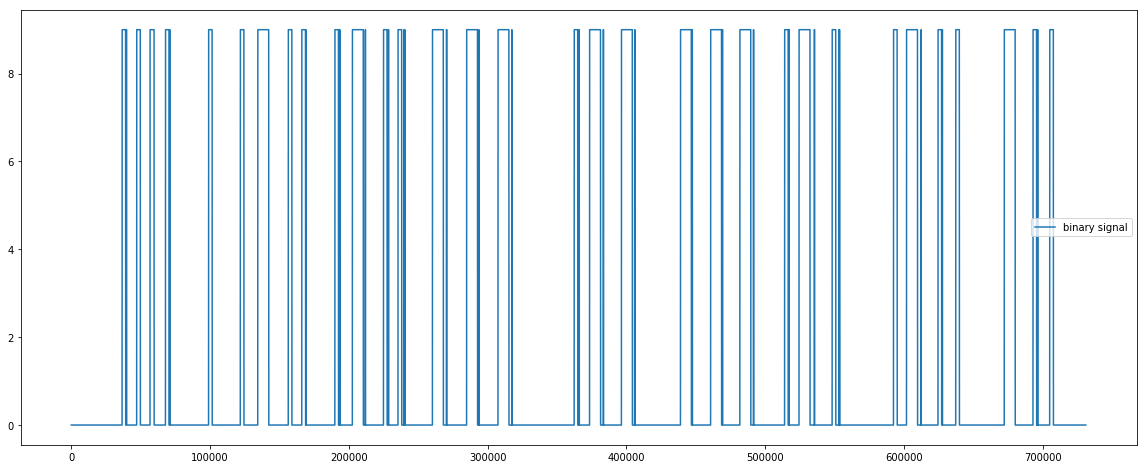

In [199]:
plot(morseCode, label='binary signal')
legend(loc='best')
pass

### 1.2 Find dash and dot from filtered signal

In [200]:
# define the length of dash and dot

def defineDotDash(inputSig):
    dotDash = []
    count = 0
    
    for sample in inputSig:
        if sample == 9:
            count += 1
        else:
            if count != 0:
                dotDash.append(count)
            count = 0
    print(dotDash)
    return dotDash
    
dotDash = defineDotDash(morseCode)

[2528, 11, 299, 3, 2, 2608, 2916, 2640, 226, 8, 5, 2, 1, 2552, 2571, 7891, 2577, 2736, 14, 2571, 91, 10, 5, 131, 7876, 35, 5, 2578, 102, 20, 8, 2637, 97, 12, 82, 5, 7840, 328, 7838, 9, 97, 5, 7846, 82, 4, 2543, 279, 1, 2, 7897, 3, 27, 7851, 222, 7818, 299, 4, 7840, 287, 8, 7851, 4, 13, 8, 2568, 101, 107, 7902, 181, 11, 2559, 11, 38, 16, 17, 81, 35, 46, 2634, 7, 7902, 47, 7, 2564, 9, 55, 82, 6, 2606, 7863, 2557, 8, 73, 30, 2628]


### 1.3 Filter message noise

In [201]:
# we have recognized most dot and dash
# now further filter out the noise

threshold2 = std(dotDash) * 0.8
print("Threshold =",int(threshold2))

morseMessage = []
for sample in dotDash:
    if sample > threshold2 and sample < threshold2 * 2:
        morseMessage.append('.')
    if sample > threshold2 * 2:
        morseMessage.append('-')

# print(morseMessage)
decodedMessage = ''.join(morseMessage)

print(decodedMessage)

Threshold = 2138
......-...-..---.-----.-..-..-..


**The result accurately decoded the message, but with space (character separator) omitted during the process.** 

The correct message should be:  
.... . .-.. .-.. --- .-- --- .-. .-.. -..  
HELLO WORLD

In [202]:
# next step is to match the result morse code with dictionary
# need a solution for omitted character sperator before I can proceed

## Part 2. image for homework 2

(731005,)
(729316,)
(854, 854, 1)
(854, 854, 3)


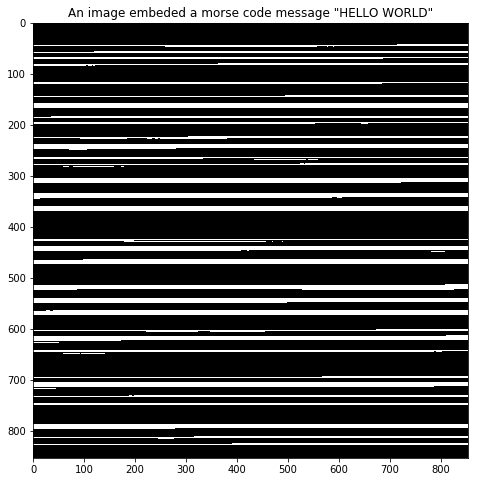

In [205]:
# dotDash[dotDash > threshold2]

hw_morse = morseCode / max(morseCode) * 1
print(shape(hw_morse))

hw_width = int(floor(sqrt(len(hw_morse))))
hw_height = hw_width
hw_morse = hw_morse[0 : hw_height*hw_width]
print(shape(hw_morse))

hw_morse = hw_morse.reshape(hw_height,hw_height,1)
print(shape(hw_morse))

hw_morse = concatenate((hw_morse, hw_morse, hw_morse), axis=2)
print(shape(hw_morse))

title('An image embeded a morse code message "HELLO WORLD"')
imshow(hw_morse,interpolation='None');


## Part 3. morse code <-> text convertor

In [ ]:
# import morse code dictionary

ENCODE = {
    "A": ".-",
    "B": "-...",
    "C": "-.-.",
    "D": "-..",
    "E": ".",
    "F": "..-.",
    "G": "--.",
    "H": "....",
    "I": "..",
    "J": ".---",
    "K": "-.-",
    "L": ".-..",
    "M": "--",
    "N": "-.",
    "O": "---",
    "P": ".--.",
    "Q": "--.-",
    "R": ".-.",
    "S": "...",
    "T": "-",
    "U": "..-",
    "V": "...-",
    "W": ".--",
    "X": "-..-",
    "Y": "-.--",
    "Z": "--..",
    "0": "-----",
    "1": ".----",
    "2": "..---",
    "3": "...--",
    "4": "....-",
    "5": ".....",
    "6": "-....",
    "7": "--...",
    "8": "---..",
    "9": "----.",
    "Ä": ".-.-",
    "Ü": "..--",
    "ß": "...--..",
    "À": ".--.-",
    "È": ".-..-",
    "É": "..-..",
    ".": ".-.-.-",
    ",": "--..--",
    ":": "---...",
    ";": "-.-.-.",
    "?": "..--..",
    "-": "-....-",
    "_": "..--.-",
    "(": "-.--.",
    ")": "-.--.-",
    "'": ".----.",
    "=": "-...-",
    "+": ".-.-.",
    "/": "-..-.",
    "@": ".--.-.",
    "Ñ": "--.--",
    " ": " ",
    "" : ""
}

# reverse to create the decoder dictionary
DECODE = {v: k for (k, v) in ENCODE.items()}

In [ ]:
# morse encoder / decoder forked from github/the-metalgamer/morse
# check user input text, remove illegal characters and encode to morse code

def removeIllegalChar(userStr):
    return filter(lambda char: char in ENCODE.keys(), userStr.capitalize())

def verify(string):
#     string = removeIllegalChar(string)
    outStr = []
    for char in string:
#         if char.capitalize() not in ENCODE.keys() and char != ' ':
        if char.capitalize() not in ENCODE.keys():
            sys.exit('Error the charcter ' + char + ' cannot be translated to Morse Code')
        else:
            outStr.append(ENCODE[char.capitalize()])
            
    print("Sure thing, chief! ", outStr)

In [ ]:
inputStr = input("What's the secret phrase? ")
verify(inputStr)

In [ ]:
testStr = '.... . .-.. .-.. --- / .-- --- .-. .-.. -..'
print(type(testStr))
print(testStr)

testStr = testStr.split()
print(type(testStr))
print(testStr)

In [ ]:
from numpy.fft import * # let's use numpy's fft
plot(real(fft(morse)))
# pass

In [ ]:
def samplePer(ms):
    return int(sampleRate / (1000 / ms))

def partialAnalyse(sample):
    fftSize = 500
    n = 0
    print(mean(sample), max(sample), min(sample), "\n")
    while True:
        if n > len(sample):
            break
        clip = sample[n : samplePer(fftSize) + n]
        n = samplePer(fftSize) + n
        print(int(max(clip)), int(min(clip)))
        pass
        

In [ ]:
partialAnalyse(morse)

## Part 4. get image from online

In [ ]:
# save web image to local

from urllib.request import (urlopen, urlparse, urlunparse, urlretrieve)
resource = urllib.request.urlopen("https://i1.wp.com/cyxu.tv/wp-content/uploads/2017/10/image3A298608_eightbit17.jpg?w=220")
output = open("file01.jpg","wb")
Image(output)
output.write(resource.read())
output.close()

In [ ]:
# save web image to local method 2

from urllib.request import urlretrieve
output = urlretrieve("https://i1.wp.com/cyxu.tv/wp-content/uploads/2017/10/image3A298608_eightbit17.jpg?w=220", "download_image.jpg")


## Part 4. get image from google

In [ ]:
# Get image from Google

#import urllib2
from urllib.request import urlopen
#import simplejson
#import cStringIO

#fetcher = urllib2.build_opener()
searchTerm = inputStr
startIndex = 0
searchUrl = str("http://ajax.googleapis.com/ajax/services/search/images?v=1.0&q=" + searchTerm + "&start=" + startIndex

html = (searchUrl)
#f = fetcher.open(searchUrl)
#deserialized_output = simplejson.load(html)
print(type(html))

In [ ]:
from bs4 import BeautifulSoup
import urllib
r = urlopen('http://www.google.com/').read()
soup = BeautifulSoup(r,"html.parser")
print(type(soup))
print(soup.prettify()[0:100])

In [ ]:
"""
dumpimages.py
    Downloads all the images on the supplied URL, and saves them to the
    specified output file ("/test/" by default)

Usage:
    python dumpimages.py http://example.com/ [output]
"""

from bs4 import BeautifulSoup as bs
from urllib.request import (urlopen, urlparse, urlunparse, urlretrieve)
import os
import sys

def main(url, out_folder="/test/"):
    """Downloads all the images at 'url' to /test/"""
    soup = bs(urlopen(url))
    parsed = list(urlparse(url))

    for image in soup.findAll("img"):
        print("Image: %(src)s" % image)
        filename = image["src"].split("/")[-1]
        parsed[2] = image["src"]
        outpath = os.path.join(out_folder, filename)
        if image["src"].lower().startswith("http"):
            urlretrieve(image["src"], outpath)
        else:
            urlretrieve(urlunparse(parsed), outpath)

def _usage():
    print("usage: python dumpimages.py http://example.com [outpath]")

if __name__ == "__main__":
    url = sys.argv[-1]
    out_folder = "/test/"
    if not url.lower().startswith("http"):
        out_folder = sys.argv[-1]
        url = sys.argv[-2]
        if not url.lower().startswith("http"):
            _usage()
            sys.exit(-1)
    main(url, out_folder)